In [ ]:
!pip install eli5 shap catboost

In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

# Tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

#ensemble(Bagging)
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor

# ensemble(boosting)
import xgboost as xgb
import lightgbm as lgb
import  catboost as cb

# 평가
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report

# 교차검증
from sklearn.model_selection import (
    KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, train_test_split
)
# Feature Selection
from sklearn.feature_selection import RFE, RFECV

# 시각화(SVM은 회귀계수가 나오지 않습니다.)
import eli5
from eli5.sklearn import PermutationImportance
import shap

# 트리 시각화
import graphviz

In [ ]:
def contours2D(model, x1, x2, h=0.01, **params):
  xx1, xx2 = np.meshgrid(
    np.arange(x1.min() - 0.1, x1.max() + 0.1, h), 
    np.arange(x2.min() - 0.1 , x2.max() + 0.1 , h)
  )

  y = model.predict(np.c_[xx1.flatten(), xx2.flatten()])
  y = y.reshape(xx1.shape)
  result = plt.contourf(xx1, xx2, y, **params)
  return result

# 결정 트리( Decision Tree)
- 정확도가 높기로 유명
- 선형 회귀, SVM, KNN 등의 특징은
 - 선 하나로 전부 분류
- 결정 트리는 여러개의 선으로 분류 시도
- 트리 깊이가 깊어질 수록 과적합

- 앙상블 기법은 일반적으로 결정 트리 알고리즘을 많이 사용


## 일반적인 샘플

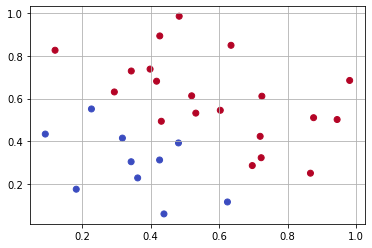

In [ ]:
np.random.seed(123)
x = np.random.rand(30,2)
y = np.zeros(len(x))
y[-4/5 + 3/4 * x[:,0] + 1 * x[:,1] > 0] = 1

x1, x2 = x[:, 0], x[:, 1]
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
plt.grid()
plt.show()

### 파라미터
- 책 188쪽 참고
1. criterion 
 - gini (불순도), entropy(복잡도)
2. max_depth : 트리의 최대 깊이 지정
 - 과적합과 관련됨
 - pruning(가지치기) 할 때 사용
3. min_depth_split : 노드 분할하기 위한 샘플의 최소 개수
 - 과적합과 관련
 - 기본값 = 2, 작게 설정할 수록 분할이 많이 일어남
 - 분할이 많이 될 수록 과적합이 될 가능성이 높음
4. min_sample_leaf : 마지막 노드가 되기 위한 샘플의 최소 개수
 - 과적합과 관련
 - 클래스 간 불균형 있을 경우에 설정 시 좋은 효과 
 - 특정 클래스의 비율이 극도로 작을 경우 이 값을 작게 설정할 필요가 있음
5. max_features : 트리 구설할 변수 최대 개수
 - 기본값은 모든 변수 사용해 트리 구성
 - 정수로 지정 -> 사용할 변수의 개수
 - 실수로 지정 -> 사용할 변수의 비율
 - 정수, 실수,'sqrt', 'log2' 중 하나로 세팅
6. max_leaf_nodes : 마지막 노드의 최대 개수
 - max_depth와 동일한 파라미터
 - max_depth 지정한 경우에는 굳이 세팅 안해도 됨
 - 최대 깊이 지정하게 되면 최대 마지막 노드 수도 정해짐, 최대 마지막 노드 수가 정해지면 최대 깊이도 정해짐

In [ ]:
# 기본 파라미터 이용
model = DecisionTreeClassifier().fit(x,y) # 최대 깊이로 자동 설정

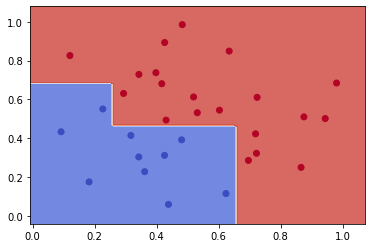

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

### 트리 시각화
- graph_vis 사용

In [ ]:
from sklearn.tree import export_graphviz

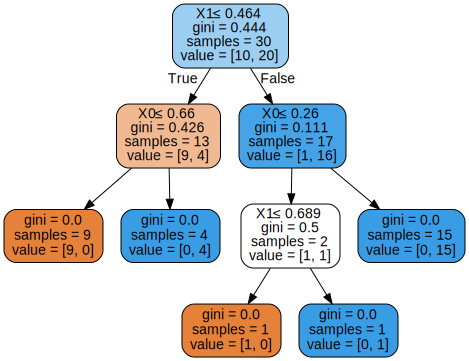

In [ ]:
data = export_graphviz(
  model, out_file=None,
  filled=True, rounded=True,
  special_characters=True
)
graph = graphviz.Source(data)
graph

gini = 불순도

## 과적합 모델

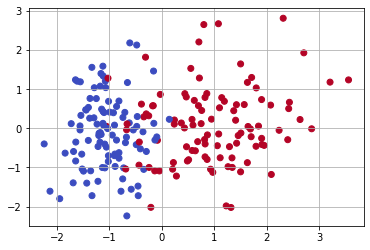

In [ ]:
x, y = datasets.make_classification(
  n_samples=200, n_features=2, n_classes=2, random_state=20220214,
  n_informative=1, n_redundant=0, n_clusters_per_class=1,
)

x1, x2 = x[:, 0], x[:, 1]
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
plt.grid()
plt.show()

In [ ]:
# 기본 파라미터 이용
model = DecisionTreeClassifier().fit(x,y) 

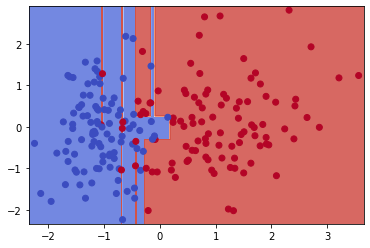

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

너무 자세하게 분할하려 하면 저런 그림이 나오게 됨

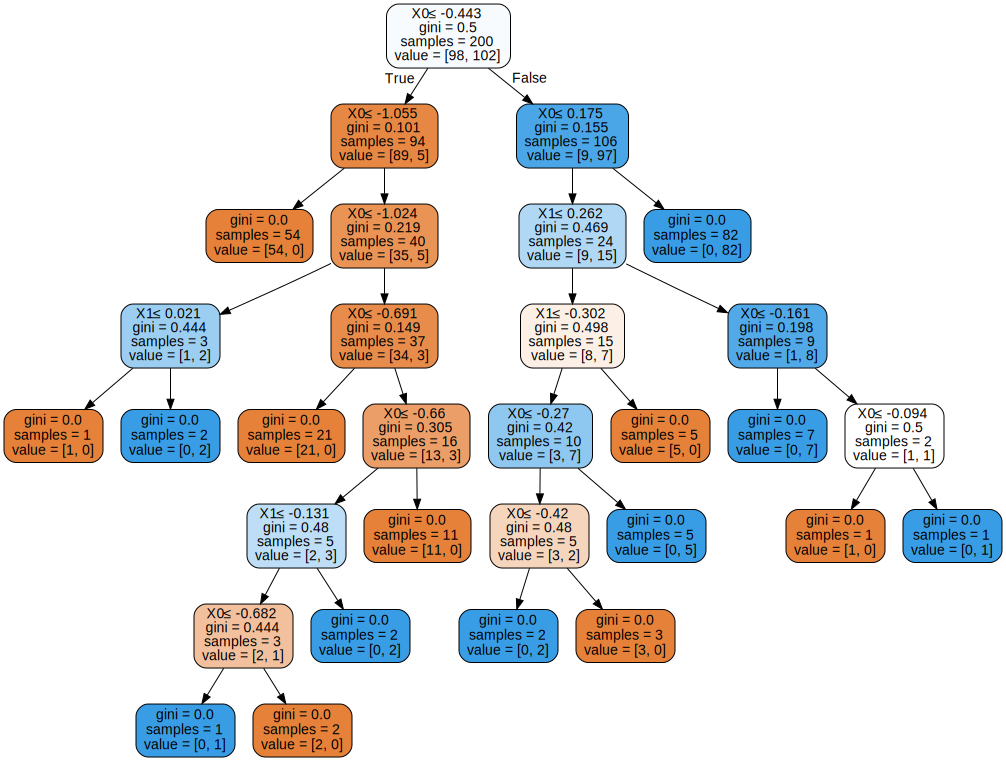

In [ ]:
data = export_graphviz(
  model, out_file=None,
  filled=True, rounded=True,
  special_characters=True
)
graph = graphviz.Source(data)
graph

### 가지치기 (Pruning)
- 트리의 최대 길이 제한
- 더 이상 노드가 새로 생기지 않게끔 설정

In [ ]:
model = DecisionTreeClassifier(max_depth=4).fit(x, y)

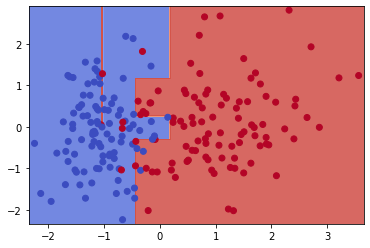

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

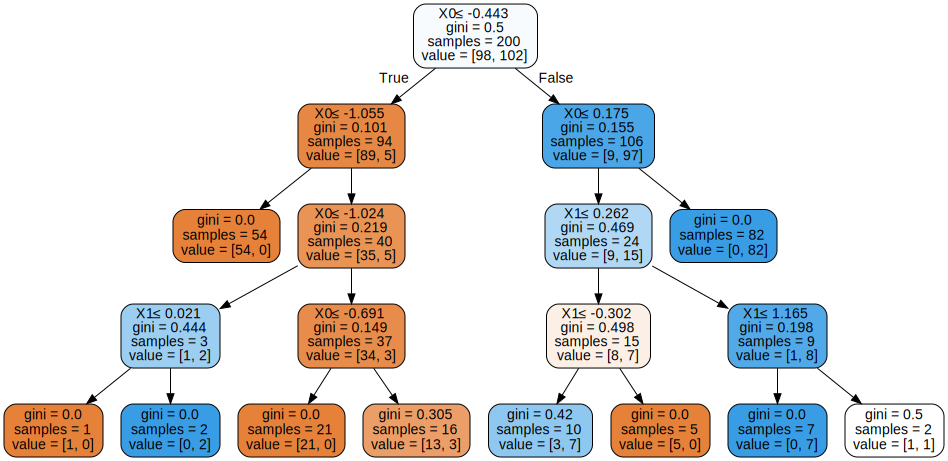

In [ ]:
data = export_graphviz(
  model, out_file=None,
  filled=True, rounded=True,
  special_characters=True
)
graph = graphviz.Source(data)
graph

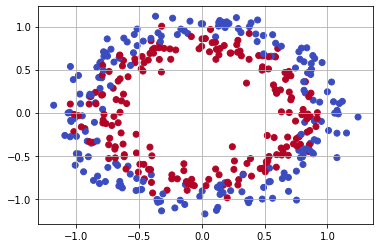

In [ ]:
x, y = datasets.make_circles(n_samples=400, noise=0.1, random_state=410)
x1, x2 = x[:, 0], x[:, 1]
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
plt.grid()
plt.show()

In [ ]:
model = DecisionTreeClassifier(max_depth=7).fit(x, y)

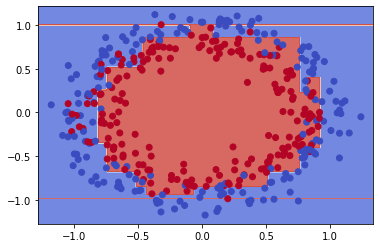

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

결정트리로는 잘 안나오는 듯

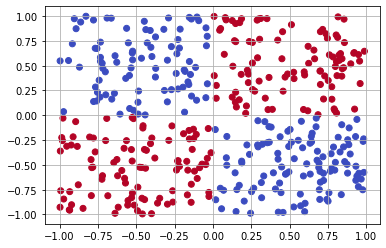

In [ ]:
np.random.seed(410)
x = np.random.uniform(-1,1, (400,2))
y = np.zeros((400), dtype=np.int32)
y[ x[:,0] * x[:,1] > 0] = 1

x1, x2 = x[:, 0], x[:, 1]
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
plt.grid()
plt.show()

In [ ]:
model = DecisionTreeClassifier().fit(x, y)

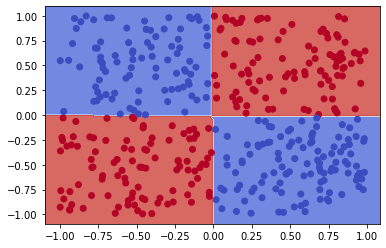

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

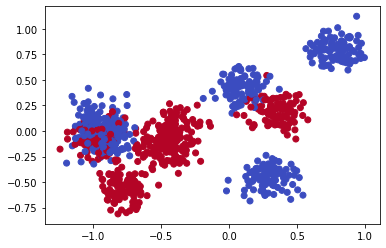

In [ ]:
x, y = datasets.make_blobs( 
  n_samples=1000, center_box=(-1, 1), centers=10, cluster_std=0.1, random_state=3)
y %= 2

x1, x2 = x[:, 0], x[:, 1]
plt.scatter( x[:, 0], x[:, 1], c=y, cmap='coolwarm')

In [ ]:
model = DecisionTreeClassifier(max_depth=4).fit(x, y)

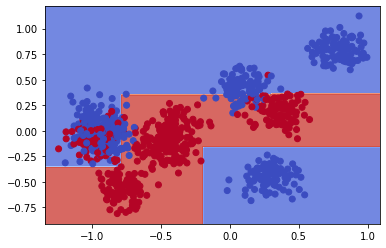

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

## 회귀

In [ ]:
np.random.seed(123)
x = np.linspace(-1, 1, 100)
y = x ** 2 + 1.5 * x + 0.5 * (2 * np.random.rand(len(x))-1)

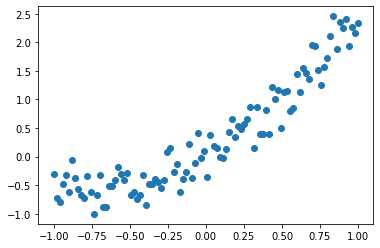

In [ ]:
plt.plot( x, y, 'o')

In [ ]:
model = DecisionTreeRegressor().fit(x.reshape(-1,1),y)

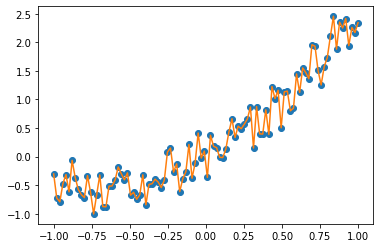

In [ ]:
plt.plot( x, y, 'o')
plt.plot( x, model.predict( x.reshape(-1,1)))
plt.show()

### 파라미터 추정

In [ ]:
params = {
  'criterion': ['squared_error', 'absolute_error'],
  'max_depth': [3, 5, 7, 9, 11, 13, 15],
  'min_samples_split': [20, 30, 40]
}

model = DecisionTreeRegressor()
search = GridSearchCV( model, param_grid=params, scoring='r2', cv=10)
results = search.fit( x.reshape(-1,1), y )

In [ ]:
print(results.best_params_)
best_model = results.best_estimator_

{'criterion': 'squared_error', 'max_depth': 3, 'min_samples_split': 20}


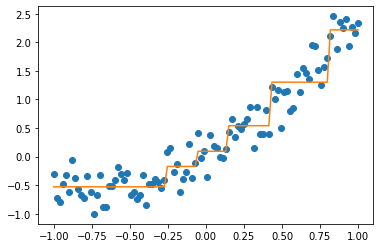

In [ ]:
plt.plot( x, y, 'o')
plt.plot( x, best_model.predict( x.reshape(-1,1)))
plt.show()

트리는 일반적으로 트리만 사용하지는 않고, 앙상블을 많이 사용함

# Ensemble ( 앙상블 )
- 여러 개의 모델을 이용해 정확도 높이는 방법
1. Bagging
 - RandomForest( 정확도 높기로 유명 )
 - 과적합에 강하다고 알려짐
 - 데이터를 병렬로 나열 후 모델 만들어서 voting 진행
 -hard voting/ soft voting
2. Boosting
 - XgBoost, LightGBM, CatBoost
 - 정확도 낮을 때 사용하면 좋다고 알려짐


## Bagging

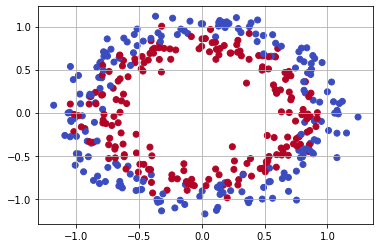

In [ ]:
x, y = datasets.make_circles(n_samples=400, noise=0.1, random_state=410)
x1, x2 = x[:, 0], x[:, 1]
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
plt.grid()
plt.show()

### Bootstrapping
직접 붓스트래핑 해보기 (원래는 라이브러리 내에서 자동 처리 가능)

In [ ]:
subSamples = []
for _ in range(11):
  # 랜덤하게 서브 샘플 만들기 위해 인덱스 추출
  idx = [x for x in range(x.shape[0])]
  
  # 생성된 인덱스 중 랜덤하게 인덱스 고르기 
  # 400개의 데이터에서 200개를 고르는 조합, 중복 인덱스 없게끔
  sample=np.random.choice(idx,x.shape[0]//2, replace=False) 
  
  #11개의 조합 생성
  subSamples.append(sample)

In [ ]:
subSamples

### 배깅
- 11개의 서브샘플을 이용해 11개의 모델 만들기

In [ ]:
bagging = []
for idx in subSamples:
  x_train=x[idx]
  y_train=y[idx]
  model=DecisionTreeClassifier().fit(x_train,y_train)
  bagging.append(model.predict(x))

In [ ]:
# 두번째 값에 대한 10개의 모델의 결과 확인해보기
for predict in bagging:
  print(predict[1])

#하드보팅을 한다면 더 많이 투표한 것으로 결정을 함 = 0으로 판단

0
0
0
1
0
0
0
1
1
0
1


-1로 판단한 모델 4, 나머지는 0으로 판단
 - 따라서 0으로 최종 결과로 사용 ( voting)

### 랜덤포레스트
- 결정트리를 이용한 대표적인 배깅 알고리즘
1. n_estimators : 트리 개수 = 서브샘플링 개수
2. 나머지는 결정트리의 파라미터와 동일

In [ ]:
params = {
  'criterion': ['gini', 'entropy'],
  # 원본셋의 개수가 400개 이므로, 서브샘플의 개수는 그보다 작아야 합니다.
  'n_estimators': [100, 300, 500, 1000],
  'max_depth': [3, 5, 7, 9, 11, 13, 15],
  'min_samples_split': [8, 16, 20],
  'min_samples_leaf': [8, 12, 18],
}

model = RandomForestClassifier()
search = GridSearchCV( model, param_grid=params, scoring='roc_auc', cv=10)
results = search.fit( x, y )

In [ ]:
print(results.best_params_)
best_model = results.best_estimator_

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 300}


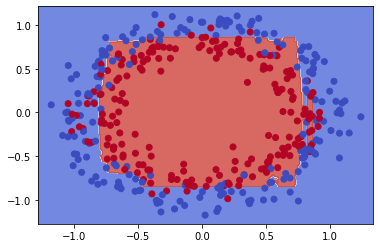

In [ ]:
contours2D(best_model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

## Boosting
- 직렬로 연결
- 서브 샘플을 만들고 오분류되는거에 가중치를 매겨서 다음 샘플에 적용하는 걸 반복.
- 학습이 진행될 수록 정확도 높아짐
- 과적합이 되기 쉬운 모델이라고 알려지지만 실제로는 ㄱㅊ음

### XGBoost
- 추정해야하는 파라미터가 엄청 많음
- 책 231쪽 참고

In [ ]:
params = {
  'eta': [0.01, 0.001],
  'num_boost_rounds': [100, 300, 500],
  'max_depth': [3, 5, 7, 9, 11, 13, 15],
  'objective': ['binary:hinge']
}

model = xgb.XGBClassifier()
search = GridSearchCV( model, param_grid=params, scoring='roc_auc', cv=5)
results = search.fit( x, y )

In [ ]:
print(results.best_params_)
best_model = results.best_estimator_

{'eta': 0.01, 'max_depth': 3, 'num_boost_rounds': 100, 'objective': 'binary:hinge'}


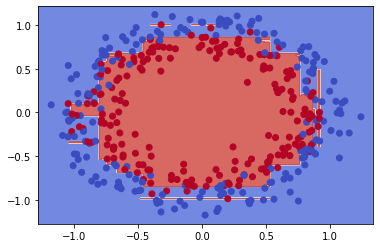

In [ ]:
contours2D(best_model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

### LightGBM
- XGBoost의 속도 개선 알고리즘
- XGBoost와 파라미터는 거의 동일

In [ ]:
params = {
  'learning_rate': [0.01, 0.001],
  'num_iterations ': [100, 300, 500],
  'max_depth': [3, 5, 7, 9, 11, 13, 15],
  'objective': ['binary']
}

model = lgb.LGBMClassifier()
search = GridSearchCV( model, param_grid=params, scoring='roc_auc', cv=5)
results = search.fit( x, y )

In [ ]:
print( results.best_params_ )
best_model = results.best_estimator_

{'learning_rate': 0.01, 'max_depth': 9, 'num_iterations ': 100, 'objective': 'binary'}


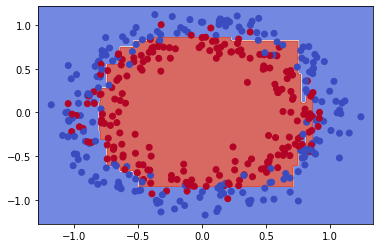

In [ ]:
contours2D(best_model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

과적합이 XGBoost보단 좀 줄은듯?

### CatBoost
- 자료가 범주형인 경우 잘 동작한다고 알려짐
- 다른 파라미터 추정 안해도 알아서 결과 추출

In [ ]:
model = cb.CatBoostClassifier().fit(x, y)

Learning rate set to 0.006966
0:	learn: 0.6906462	total: 48.8ms	remaining: 48.8s
1:	learn: 0.6884001	total: 50ms	remaining: 24.9s
2:	learn: 0.6860735	total: 51.9ms	remaining: 17.3s
3:	learn: 0.6839346	total: 53.9ms	remaining: 13.4s
4:	learn: 0.6816658	total: 55.6ms	remaining: 11.1s
5:	learn: 0.6789914	total: 57.5ms	remaining: 9.52s
6:	learn: 0.6764810	total: 58.4ms	remaining: 8.28s
7:	learn: 0.6740872	total: 59.4ms	remaining: 7.37s
8:	learn: 0.6715738	total: 60.5ms	remaining: 6.66s
9:	learn: 0.6695618	total: 61.5ms	remaining: 6.09s
10:	learn: 0.6675955	total: 62.7ms	remaining: 5.64s
11:	learn: 0.6653240	total: 66.9ms	remaining: 5.51s
12:	learn: 0.6634218	total: 68.1ms	remaining: 5.17s
13:	learn: 0.6609600	total: 70.7ms	remaining: 4.98s
14:	learn: 0.6575228	total: 72ms	remaining: 4.72s
15:	learn: 0.6556575	total: 74.7ms	remaining: 4.59s
16:	learn: 0.6533494	total: 77.2ms	remaining: 4.47s
17:	learn: 0.6513081	total: 79ms	remaining: 4.31s
18:	learn: 0.6492806	total: 80ms	remaining: 4.13s


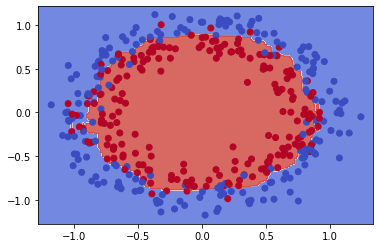

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

다른 파라미터를 설정하지 않아도 꽤 정확한 결과를 보여줌

# Stacking
- 여러 개 다른 모델 이용해서 정확도 높임
- 여러 모델을 층층히 쌓아서 정확도 높임

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier, StackingRegressor

In [ ]:
# base learner
estimators = [
  # 파라미터를 미리 추정했어야 하는데 실습은 디폴트 파라미터로 진행
  ('RandomForest', RandomForestClassifier() ),
  ('XGBoost', xgb.XGBClassifier() ), 
  ('LGBM', lgb.LGBMClassifier() ),
  ('CB', cb.CatBoostClassifier() )
]

# meta learner
model = StackingClassifier( estimators=estimators, final_estimator=LogisticRegression() )
model.fit(x, y)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4:	learn: 0.6805132	total: 4.9ms	remaining: 976ms
5:	learn: 0.6783412	total: 5.95ms	remaining: 985ms
6:	learn: 0.6762476	total: 6.98ms	remaining: 990ms
7:	learn: 0.6738612	total: 7.96ms	remaining: 988ms
8:	learn: 0.6719161	total: 8.95ms	remaining: 986ms
9:	learn: 0.6698101	total: 10ms	remaining: 990ms
10:	learn: 0.6683043	total: 11ms	remaining: 991ms
11:	learn: 0.6661109	total: 12ms	remaining: 988ms
12:	learn: 0.6639508	total: 13ms	remaining: 986ms
13:	learn: 0.6619727	total: 14.1ms	remaining: 991ms
14:	learn: 0.6587265	total: 15.1ms	remaining: 991ms
15:	learn: 0.6571963	total: 16.2ms	remaining: 995ms
16:	learn: 0.6550666	total: 17.2ms	remaining: 993ms
17:	learn: 0.6529677	total: 18.2ms	remaining: 991ms
18:	learn: 0.6511531	total: 19.2ms	remaining: 993ms
19:	learn: 0.6501256	total: 20.2ms	remaining: 992ms
20:	learn: 0.6473191	total: 21.2ms	remaining: 990ms
21:	learn: 0.6448870	total: 22.3ms	remaining: 991ms
22:	learn: 0.6428312	total: 23.3ms	remainin

StackingClassifier(estimators=[('RandomForest', RandomForestClassifier()),
                               ('XGBoost', XGBClassifier()),
                               ('LGBM', LGBMClassifier()),
                               ('CB',
                                <catboost.core.CatBoostClassifier object at 0x7f67d0d4b250>)],
                   final_estimator=LogisticRegression())

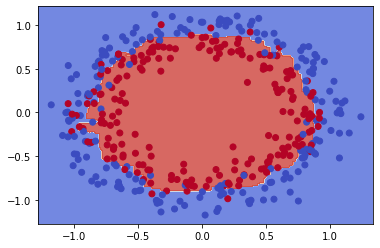

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()

## 여러개 레이어

In [ ]:
# base learner
estimators_one = [
  # 파라미터를 미리 추정했어야 하는데 실습은 디폴트 파라미터로 진행
  ('RandomForest', RandomForestClassifier() ),
  ('XGBoost', xgb.XGBClassifier() ), 
  ('LGBM', lgb.LGBMClassifier() ),
  ('CB', cb.CatBoostClassifier() )
]

estimators_two = [
  # 파라미터를 미리 추정했어야 하는데 실습은 디폴트 파라미터로 진행
  ('SVM', SVC() ),
  ('KNN', KNeighborsClassifier() ), 
]

# meta learner
layer_two = StackingClassifier( estimators=estimators_two, final_estimator=LogisticRegression() )
model = StackingClassifier( estimators=estimators_one, final_estimator=layer_two, cv=10 )
model.fit(x, y)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4:	learn: 0.6799400	total: 5.19ms	remaining: 1.03s
5:	learn: 0.6770959	total: 6.24ms	remaining: 1.03s
6:	learn: 0.6752767	total: 7.29ms	remaining: 1.03s
7:	learn: 0.6729561	total: 8.27ms	remaining: 1.02s
8:	learn: 0.6705935	total: 9.34ms	remaining: 1.03s
9:	learn: 0.6683467	total: 10.5ms	remaining: 1.03s
10:	learn: 0.6658323	total: 11.6ms	remaining: 1.04s
11:	learn: 0.6636745	total: 12.6ms	remaining: 1.04s
12:	learn: 0.6617715	total: 13.7ms	remaining: 1.04s
13:	learn: 0.6594686	total: 14.6ms	remaining: 1.03s
14:	learn: 0.6564725	total: 15.7ms	remaining: 1.03s
15:	learn: 0.6543349	total: 16.5ms	remaining: 1.01s
16:	learn: 0.6519599	total: 17.5ms	remaining: 1.01s
17:	learn: 0.6503264	total: 18.5ms	remaining: 1.01s
18:	learn: 0.6484292	total: 19.6ms	remaining: 1.01s
19:	learn: 0.6464860	total: 20.6ms	remaining: 1.01s
20:	learn: 0.6444608	total: 21.9ms	remaining: 1.02s
21:	learn: 0.6421975	total: 22.9ms	remaining: 1.02s
22:	learn: 0.6404934	total: 24ms	r

StackingClassifier(cv=10,
                   estimators=[('RandomForest', RandomForestClassifier()),
                               ('XGBoost', XGBClassifier()),
                               ('LGBM', LGBMClassifier()),
                               ('CB',
                                <catboost.core.CatBoostClassifier object at 0x7f67d0d99f90>)],
                   final_estimator=StackingClassifier(estimators=[('SVM',
                                                                   SVC()),
                                                                  ('KNN',
                                                                   KNeighborsClassifier())],
                                                      final_estimator=LogisticRegression()))

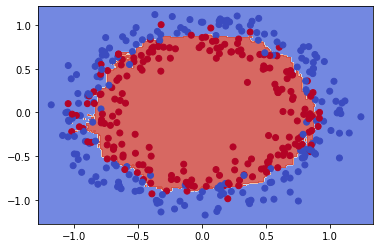

In [ ]:
contours2D(model, x1, x2, cmap='coolwarm', alpha=0.8)
plt.scatter(x1, x2, c=y, cmap='coolwarm')
plt.show()